# Sky coverage

In [25]:
import matplotlib.pyplot as plt
from pycbc.detector import Detector
import numpy as np
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from itertools import combinations
import pandas as pd
from itertools import combinations
import os
from pycbc.waveform import get_fd_waveform
from pycbc.psd import aLIGOZeroDetHighPower


In [26]:
n=1000000

#for uniform points on sphere
ra = np.random.uniform(0,2*np.pi,n)
dec = np.pi/2 - np.arccos(np.random.uniform(-1,1,n))

pol = 0  
t = 1e10  

#LIGO India
class LigoIndia(Detector):
    def __init__(self, name, latitude, longitude, orientation):
        self.name = name
        self.latitude = latitude
        self.longitude = longitude
        self.orientation = orientation
        super().__init__(name)
ligo_india_latitude = np.radians(19.613306) 
ligo_india_longitude = np.radians(77.030861)  
ligo_india_orientation = np.radians(45.0)  

detectors = [Detector("L1"),Detector("H1"),Detector("K1"),Detector("V1"),
             LigoIndia("I1", ligo_india_latitude, ligo_india_longitude, ligo_india_orientation)]


In [27]:
rho_min = 8

d = Detector("L1")

# Antenna pattern
fp, fc = d.antenna_pattern(ra, dec, pol, t)

hp, hc = get_fd_waveform(approximant="TaylorF2",
                         mass1=5,
                         mass2=10,
                         f_lower=20,
                         delta_f=1.0 / 16, 
                         distance=1500)     # distance in Mpc

H_f_squared = abs(hp)**2 + abs(hc)**2

psd = aLIGOZeroDetHighPower(len(hp), hp.delta_f, 0.0)

# Avoid divide by zero
valid = psd > 0
rho_sq_source = ((H_f_squared[valid] / psd[valid]) * hp.delta_f).sum()


## Single Detector

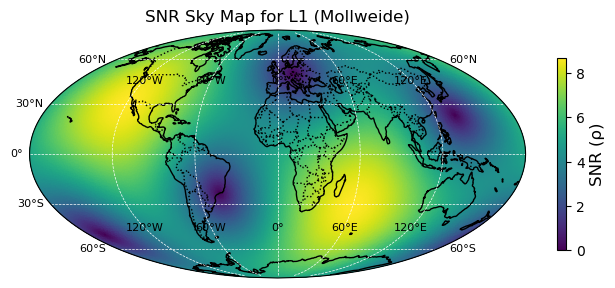

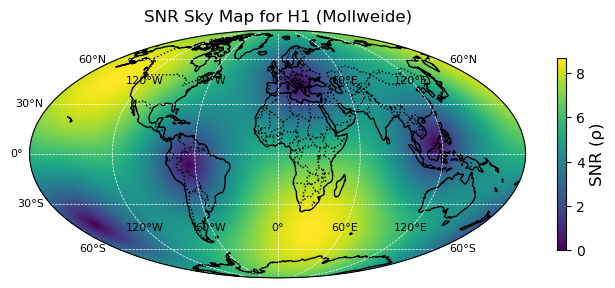

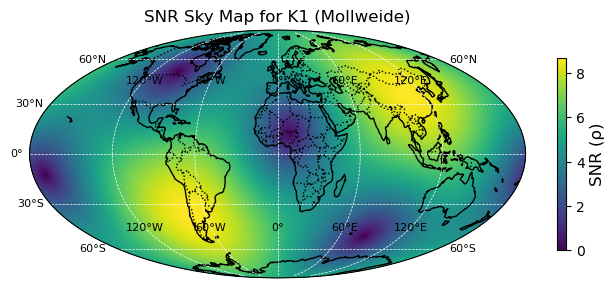

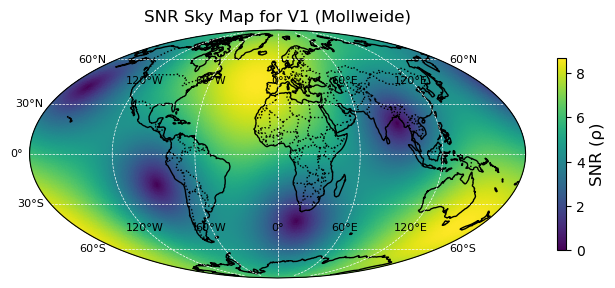

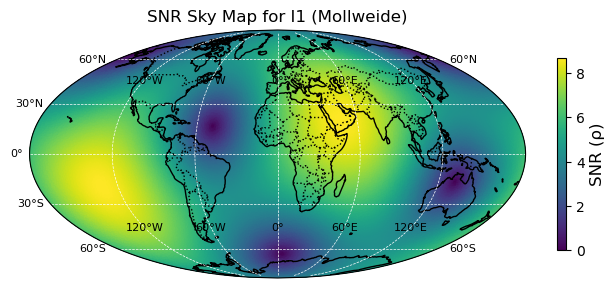

  Detector  Sky coverage (%)
0       L1            8.1795
1       H1            8.1354
2       K1            8.2313
3       V1            8.2187
4       I1            8.2096


In [28]:
table_data = []
folder = "figures"
os.makedirs(folder, exist_ok=True)

for d in detectors:
    fp, fc = d.antenna_pattern(ra, dec, pol, t)
    rho_sq_total = 2 * (fp**2 + fc**2) * rho_sq_source
    rho = np.sqrt(rho_sq_total)

    above_threshold = np.sum(rho > rho_min)
    total_points = len(rho)
    area_covered = 100 * above_threshold / total_points

    # Mollweide projection 
    ra_mollweide = ra.copy()
    ra_mollweide[ra > np.pi] -= 2 * np.pi
    ra_deg = np.degrees(ra_mollweide)
    dec_deg = np.degrees(dec)

    fig = plt.figure(figsize=[8, 5])
    ax = fig.add_subplot(111, projection=ccrs.Mollweide())
    ax.add_feature(cfeature.COASTLINE, linewidth=1)
    ax.add_feature(cfeature.BORDERS, linestyle=":", linewidth=1)
    ax.set_global()

    scatter = ax.scatter(
        ra_deg,
        dec_deg,
        c=rho,
        cmap="viridis",
        s=2,
        edgecolors="none",
        transform=ccrs.PlateCarree(),
        vmin=0,
        vmax=np.max(rho),
    )

    gl = ax.gridlines(draw_labels=True, linestyle="--", linewidth=0.5, color="white")
    gl.top_labels = False
    gl.right_labels = False
    gl.xlabel_style = {"size": 8}
    gl.ylabel_style = {"size": 8}
    plt.title(f"SNR Sky Map for {d.name} (Mollweide)", fontsize=12)

    cbar = plt.colorbar(scatter, ax=ax, shrink=0.5, orientation="vertical", pad=0.05)
    cbar.set_label("SNR (ρ)", fontsize=12)
    file_path = os.path.join(folder, f"{d.name}.pdf")
    plt.savefig(file_path, format='pdf')
    plt.show()
   
    plt.close()
    table_data.append({
        "Detector": d.name,
        "Sky coverage (%)": area_covered
    })

table_df = pd.DataFrame(table_data)
print(table_df)




## Two detectors

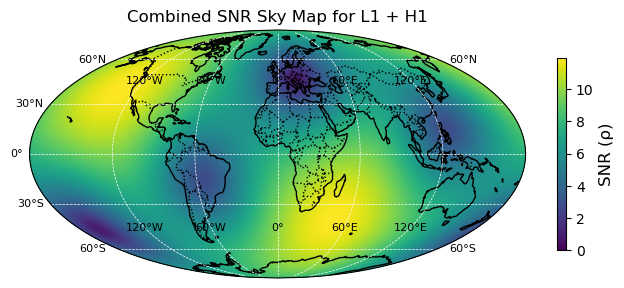

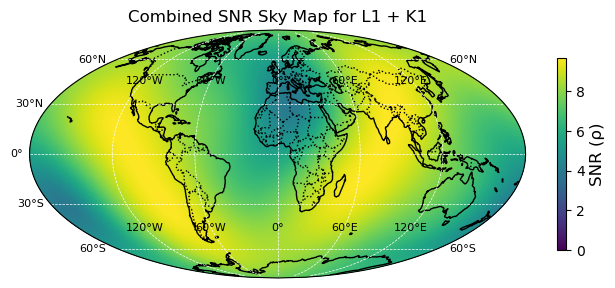

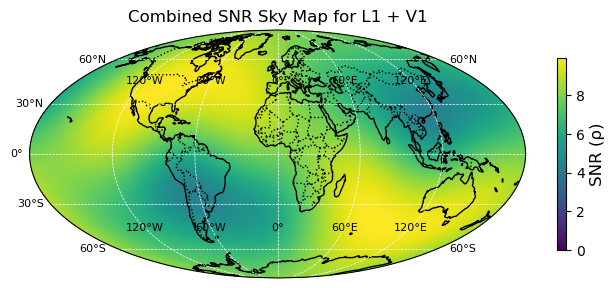

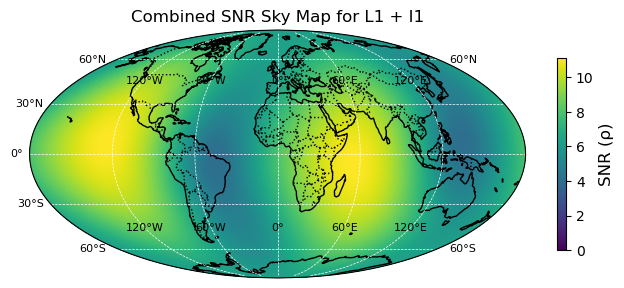

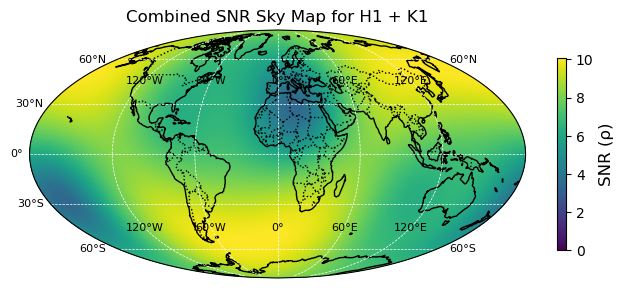

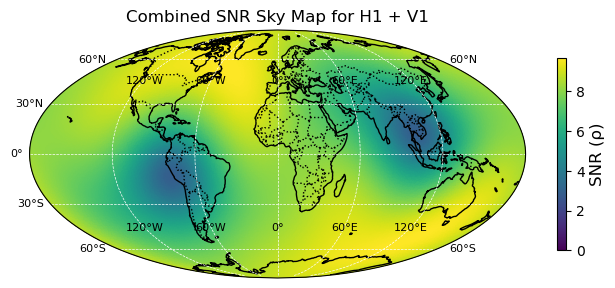

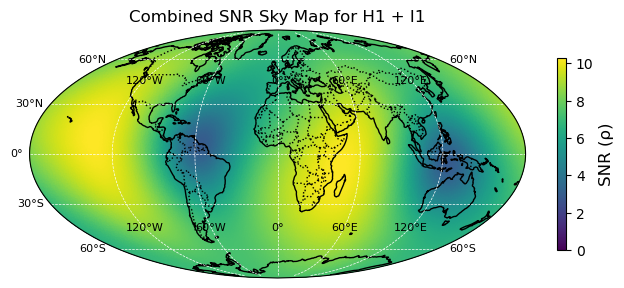

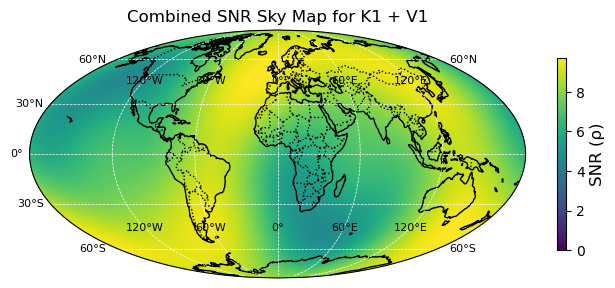

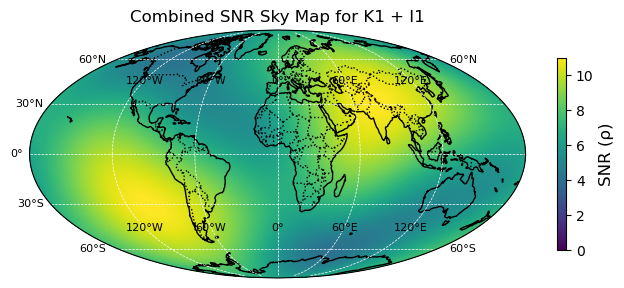

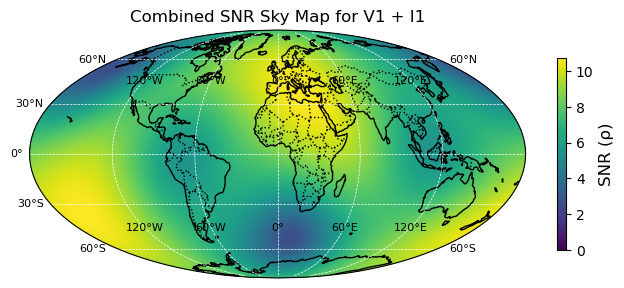

  Detectors  Sky coverage (%)
0   L1 + H1           39.4880
1   L1 + K1           47.8929
2   L1 + V1           46.7503
3   L1 + I1           39.9322
4   H1 + K1           44.7816
5   H1 + V1           51.2003
6   H1 + I1           42.2802
7   K1 + V1           47.2904
8   K1 + I1           40.2318
9   V1 + I1           40.7271


In [29]:
# 2-detector combinations
table_data = []

for d1, d2 in combinations(detectors, 2):
    fp1, fc1 = d1.antenna_pattern(ra, dec, pol, t)
    fp2, fc2 = d2.antenna_pattern(ra, dec, pol, t)

    rho1_sq = 2 * (fp1**2 + fc1**2) * rho_sq_source
    rho2_sq = 2 * (fp2**2 + fc2**2) * rho_sq_source

    rho_sq_total = rho1_sq + rho2_sq
    rho = np.sqrt(rho_sq_total)

    above_threshold = np.sum(rho > rho_min)
    area_covered = 100 * above_threshold / len(rho)

    # Mollweide projection
    ra_mollweide = ra.copy()
    ra_mollweide[ra > np.pi] -= 2 * np.pi
    ra_deg = np.degrees(ra_mollweide)
    dec_deg = np.degrees(dec)

    fig = plt.figure(figsize=[8, 5])
    ax = fig.add_subplot(111, projection=ccrs.Mollweide())
    ax.add_feature(cfeature.COASTLINE, linewidth=1)
    ax.add_feature(cfeature.BORDERS, linestyle=":", linewidth=1)
    ax.set_global()

    scatter = ax.scatter(
        ra_deg,
        dec_deg,
        c=rho,
        cmap="viridis",
        s=2,
        edgecolors="none",
        transform=ccrs.PlateCarree(),
        vmin=0,
        vmax=np.max(rho),
    )

    gl = ax.gridlines(draw_labels=True, linestyle="--", linewidth=0.5, color="white")
    gl.top_labels = False
    gl.right_labels = False
    gl.xlabel_style = {"size": 8}
    gl.ylabel_style = {"size": 8}

    plt.title(f"Combined SNR Sky Map for {d1.name} + {d2.name}", fontsize=12)
    cbar = plt.colorbar(scatter, ax=ax, shrink=0.5, orientation="vertical", pad=0.05)
    cbar.set_label("SNR (ρ)", fontsize=12)
    file_path = os.path.join(folder, f"{d.name} + {d2.name}.pdf")
    plt.savefig(file_path, format='pdf')
    plt.show()
    plt.close()

    table_data.append({
        "Detectors": f"{d1.name} + {d2.name}",
        "Sky coverage (%)": area_covered
    })

# Display table
table_df = pd.DataFrame(table_data)
print(table_df)


## Three detectors

### three detectors: with same PSD

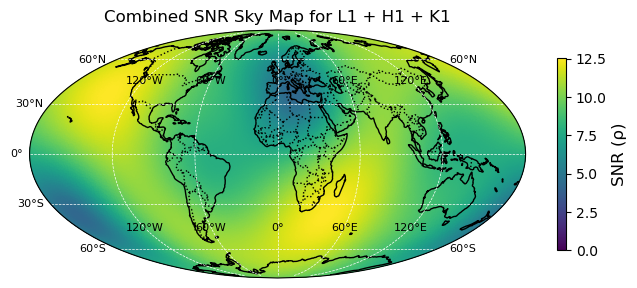

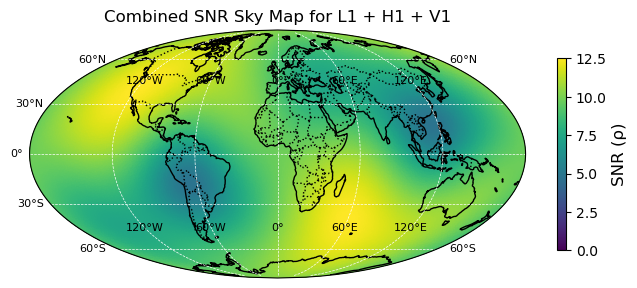

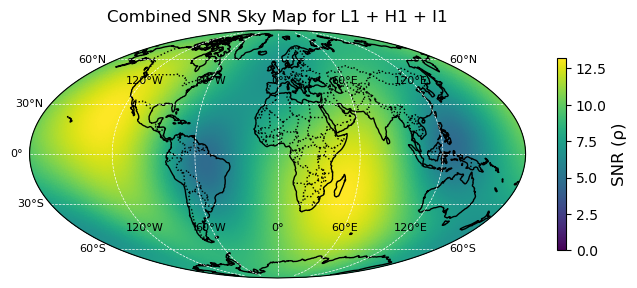

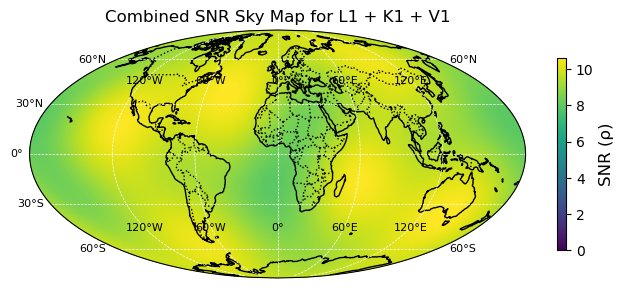

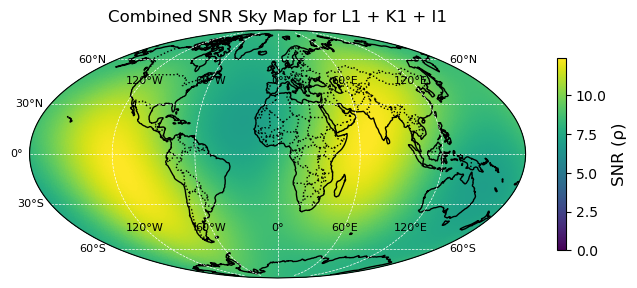

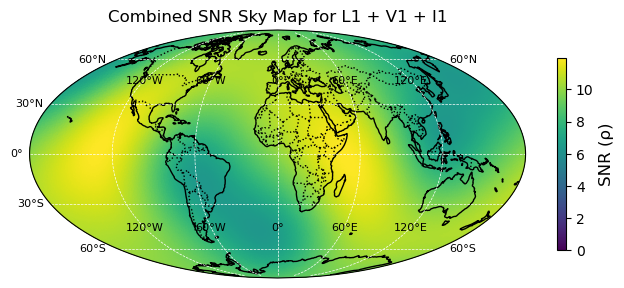

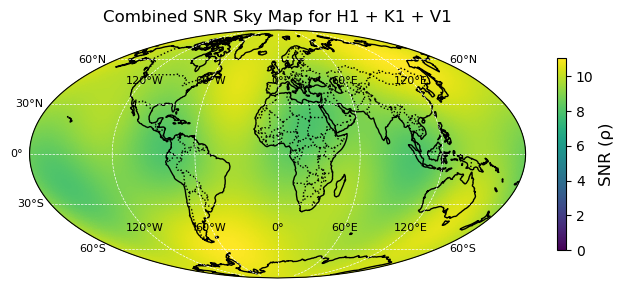

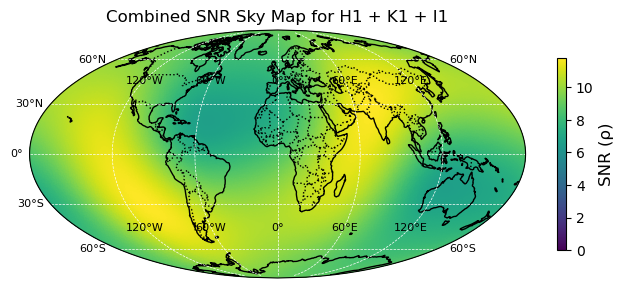

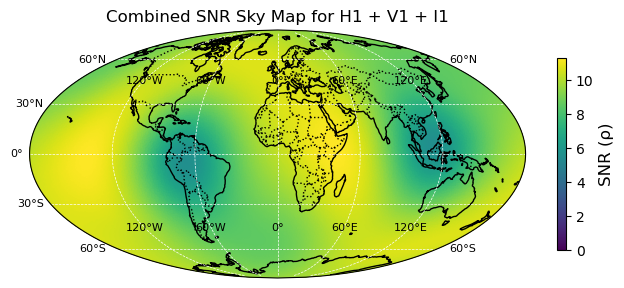

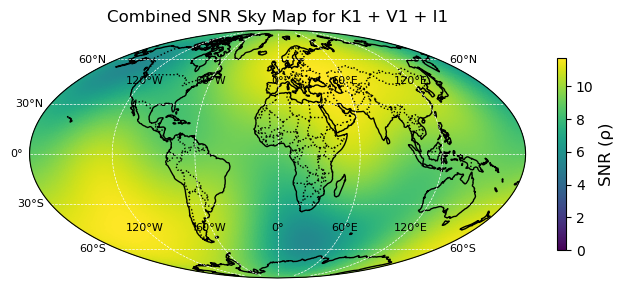

      Detectors  Sky coverage (%)
0  L1 + H1 + K1           77.0843
1  L1 + H1 + V1           75.9345
2  L1 + H1 + I1           70.3194
3  L1 + K1 + V1           99.1105
4  L1 + K1 + I1           79.2358
5  L1 + V1 + I1           76.3625
6  H1 + K1 + V1           98.6115
7  H1 + K1 + I1           79.3252
8  H1 + V1 + I1           85.8673
9  K1 + V1 + I1           83.3645


In [30]:
# 3-detector combinations
table_data = []

for d1, d2, d3 in combinations(detectors, 3):
    rho_sq_total = np.zeros_like(ra)

    for d in [d1, d2, d3]:
        fp, fc = d.antenna_pattern(ra, dec, pol, t)
        rho_sq = 2 * (fp**2 + fc**2) * rho_sq_source
        rho_sq_total += rho_sq

    rho = np.sqrt(rho_sq_total)

    above_threshold = np.sum(rho > rho_min)
    area_covered = 100 * above_threshold / len(rho)

    ra_mollweide = ra.copy()
    ra_mollweide[ra > np.pi] -= 2 * np.pi
    ra_deg = np.degrees(ra_mollweide)
    dec_deg = np.degrees(dec)

    fig = plt.figure(figsize=[8, 5])
    ax = fig.add_subplot(111, projection=ccrs.Mollweide())
    ax.add_feature(cfeature.COASTLINE, linewidth=1)
    ax.add_feature(cfeature.BORDERS, linestyle=":", linewidth=1)
    ax.set_global()

    scatter = ax.scatter(
        ra_deg,
        dec_deg,
        c=rho,
        cmap="viridis",
        s=2,
        edgecolors="none",
        transform=ccrs.PlateCarree(),
        vmin=0,
        vmax=np.max(rho),
    )

    gl = ax.gridlines(draw_labels=True, linestyle="--", linewidth=0.5, color="white")
    gl.top_labels = False
    gl.right_labels = False
    gl.xlabel_style = {"size": 8}
    gl.ylabel_style = {"size": 8}

    plt.title(f"Combined SNR Sky Map for {d1.name} + {d2.name} + {d3.name}", fontsize=12)
    cbar = plt.colorbar(scatter, ax=ax, shrink=0.5, orientation="vertical", pad=0.05)
    cbar.set_label("SNR (ρ)", fontsize=12)

    file_path = os.path.join(folder, f"{d.name} + {d2.name} + {d3.name}.pdf")
    plt.savefig(file_path, format='pdf')
    plt.show()
    plt.close()

    table_data.append({
        "Detectors": f"{d1.name} + {d2.name} + {d3.name}",
        "Sky coverage (%)": area_covered
    })
table_df = pd.DataFrame(table_data)
print(table_df)


## Four detectors

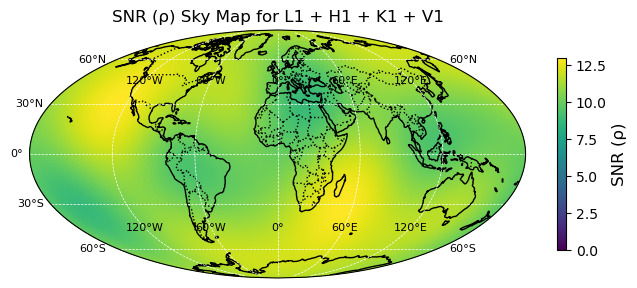

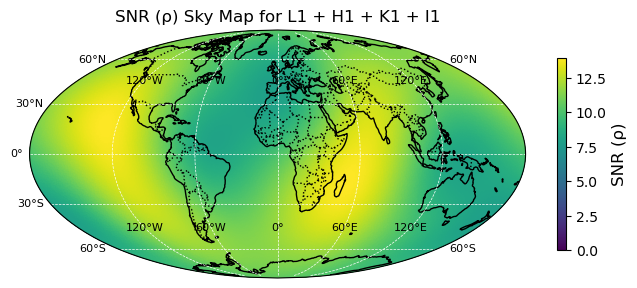

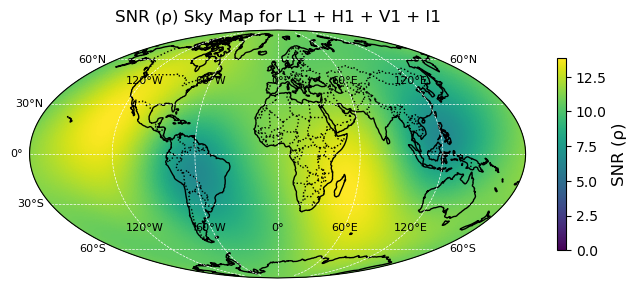

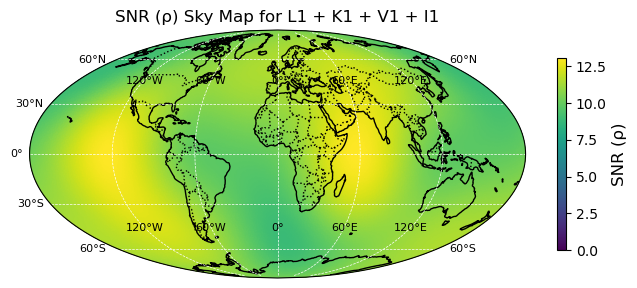

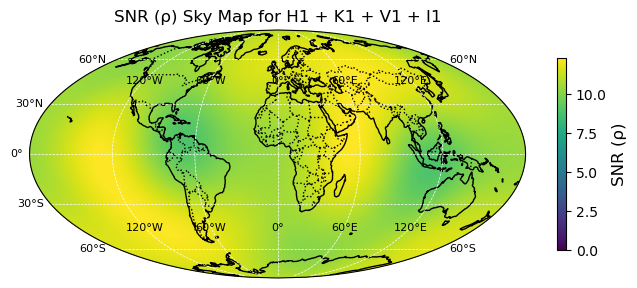

           Detectors  Sky coverage (%)
0  L1 + H1 + K1 + V1          100.0000
1  L1 + H1 + K1 + I1           98.7549
2  L1 + H1 + V1 + I1           93.2267
3  L1 + K1 + V1 + I1          100.0000
4  H1 + K1 + V1 + I1          100.0000


In [31]:
table_data = []

# 4-detector combinations
for d1, d2, d3, d4 in combinations(detectors, 4):
    rho_sq_total = np.zeros_like(ra)

    for d in [d1, d2, d3, d4]:
        fp, fc = d.antenna_pattern(ra, dec, pol, t)
        rho_sq = 2 * (fp**2 + fc**2) * rho_sq_source
        rho_sq_total += rho_sq

    rho = np.sqrt(rho_sq_total)

    above_threshold = np.sum(rho > rho_min)
    area_covered = 100 * above_threshold / len(rho)

    ra_mollweide = ra.copy()
    ra_mollweide[ra > np.pi] -= 2 * np.pi
    ra_deg = np.degrees(ra_mollweide)
    dec_deg = np.degrees(dec)

    fig = plt.figure(figsize=[8, 5])
    ax = fig.add_subplot(111, projection=ccrs.Mollweide())
    ax.add_feature(cfeature.COASTLINE, linewidth=1)
    ax.add_feature(cfeature.BORDERS, linestyle=":", linewidth=1)
    ax.set_global()

    scatter = ax.scatter(
        ra_deg,
        dec_deg,
        c=rho,
        cmap="viridis",
        s=2,
        edgecolors="none",
        transform=ccrs.PlateCarree(),
        vmin=0,
        vmax=np.max(rho),
    )

    gl = ax.gridlines(draw_labels=True, linestyle="--", linewidth=0.5, color="white")
    gl.top_labels = False
    gl.right_labels = False
    gl.xlabel_style = {"size": 8}
    gl.ylabel_style = {"size": 8}

    plt.title(f"SNR (ρ) Sky Map for {d1.name} + {d2.name} + {d3.name} + {d4.name}", fontsize=12)
    cbar = plt.colorbar(scatter, ax=ax, shrink=0.5, orientation="vertical", pad=0.05)
    cbar.set_label("SNR (ρ)", fontsize=12)

    file_path = os.path.join(folder, f"{d.name} + {d2.name} + {d3.name} + {d4.name}.pdf")
    plt.savefig(file_path, format='pdf')
    plt.show()
    plt.close()

    table_data.append({
        "Detectors": f"{d1.name} + {d2.name} + {d3.name} + {d4.name}",
        "Sky coverage (%)": area_covered
    })

table_df = pd.DataFrame(table_data)
print(table_df)


## All five detectors

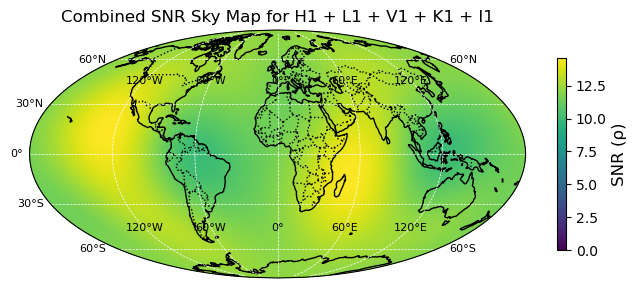

                Detectors  Sky coverage (%)
0  H1 + L1 + V1 + K1 + I1             100.0


In [32]:
# combined rho^2 for all five detectors
table_data =[]
rho_sq_total = np.zeros_like(ra)

for d in detectors:
    fp, fc = d.antenna_pattern(ra, dec, pol, t)
    rho_sq = 2 * (fp**2 + fc**2) * rho_sq_source
    rho_sq_total += rho_sq

rho = np.sqrt(rho_sq_total)

above_threshold = np.sum(rho > rho_min)
area_covered = 100 * above_threshold / len(rho)

ra_mollweide = ra.copy()
ra_mollweide[ra > np.pi] -= 2 * np.pi
ra_deg = np.degrees(ra_mollweide)
dec_deg = np.degrees(dec)

fig = plt.figure(figsize=[8, 5])
ax = fig.add_subplot(111, projection=ccrs.Mollweide())
ax.add_feature(cfeature.COASTLINE, linewidth=1)
ax.add_feature(cfeature.BORDERS, linestyle=":", linewidth=1)
ax.set_global()

scatter = ax.scatter(
    ra_deg,
    dec_deg,
    c=rho,
    cmap="viridis",
    s=2,
    edgecolors="none",
    transform=ccrs.PlateCarree(),
    vmin=0,
    vmax=np.max(rho),
)

gl = ax.gridlines(draw_labels=True, linestyle="--", linewidth=0.5, color="white")
gl.top_labels = False
gl.right_labels = False
gl.xlabel_style = {"size": 8}
gl.ylabel_style = {"size": 8}

plt.title("Combined SNR Sky Map for H1 + L1 + V1 + K1 + I1", fontsize=12)
cbar = plt.colorbar(scatter, ax=ax, shrink=0.5, orientation="vertical", pad=0.05)
cbar.set_label("SNR (ρ)", fontsize=12)

file_path = os.path.join(folder, f"{d.name} + {d2.name}.pdf")
plt.savefig(file_path, format='pdf')
plt.show()
plt.close()

table_data.append({
        "Detectors": f"H1 + L1 + V1 + K1 + I1",
        "Sky coverage (%)": area_covered
    })

table_df = pd.DataFrame(table_data)
print(table_df)
